In this notebook we compare the performance of Kmeans and Affinity propagation on 3 toy datasets

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans,AffinityPropagation
from sklearn.metrics.pairwise import euclidean_distances

In [43]:
data_1=pd.read_csv("cluster1.csv",header=None)
data_1.columns=['x1','x2','label']
data_2=pd.read_csv("cluster2.csv",header=None)
data_2.columns=['x1','x2','label']
data_3=pd.read_csv("cluster3.csv",header=None)
data_3.columns=['x1','x2','label']

# DataSet 1

We first explore our dataset

In [44]:
data_1.head()

,x1,x2,label
0,5.867498,8.177152,0.0
1,5.613700,9.932955,0.0
2,7.225084,10.448862,0.0
3,6.762823,0.605145,1.0
4,8.016182,1.543147,1.0


In [45]:
data_1['label'].value_counts()

2.0    500
1.0    500
0.0    500
Name: label, dtype: int64

Text(0.5,1,'Original data with Labels')

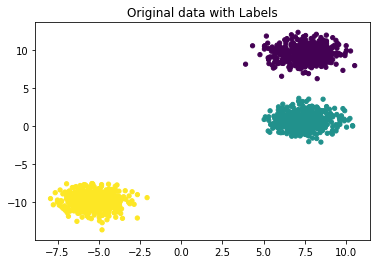

In [4]:
plt.scatter(x=data_1.iloc[:,0],y=data_1.iloc[:,1],c=data_1.iloc[:,2],s=18)
plt.title("Original data with Labels")

We can see from the above that the dataset has three clearly separable clusters

In [47]:
data_1_wo_labels=data_1.drop(columns=['label'])
X=data_1_wo_labels.values

**KMeans**

Now we apply Kmeans with different number of clusters as an input and explore the clustering results, the n_init parameter in the Kmeans function is set to 10, which refers to the number of times the algorithm is run. Since Kmeans is prone to initialization and can fall into a local minimum, we need to run the algorithm a couple of times and consider the most appropriate result.

In [24]:
k=2
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=2')

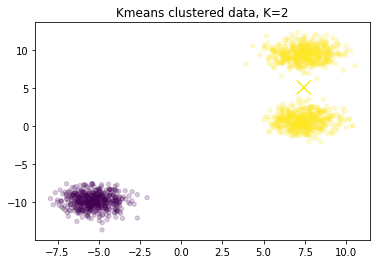

In [25]:
plt.scatter(x=data_1_wo_labels.iloc[:,0],y=data_1_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=2")

The above results show the clustering with k=2, we can see that the yellow center is set between the two original yellow clusters which is understandable.

In [26]:
k=3
Kmeans=KMeans(n_clusters=k,n_init=1).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=3')

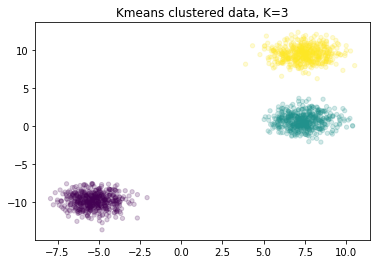

In [29]:
plt.scatter(x=data_1_wo_labels.iloc[:,0],y=data_1_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=3")

Here we considered K=3 which is equivalent to the original clustering. 
We can see that we almost have identical clusters to the ones in the original data which again comes as no surprise since there are 3 clear groups in the data. Hence, they are fairly separable

In [30]:
k=4
Kmeans=KMeans(n_clusters=k,n_init=1).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=4')

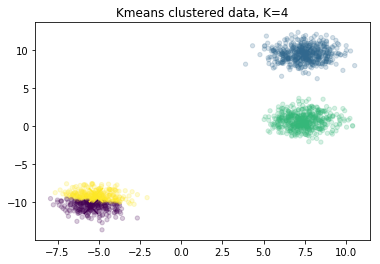

In [33]:
plt.scatter(x=data_1_wo_labels.iloc[:,0],y=data_1_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=4")

The above plot shows the results from K=4, we can see that the lower cluster is now split into two

In [38]:
k=5
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=5')

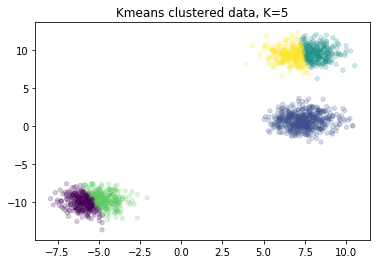

In [39]:
plt.scatter(x=data_1_wo_labels.iloc[:,0],y=data_1_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=5")

The above plot shows the results for K=5. Both the upper and the lower class are now split into two.

** Affinity Propagation **

Next we apply Affinity propagation to our dataset.According to the original paper for the algorithm from Brendan J. Frey and Delbert Dueck
http://www.psi.toronto.edu/affinitypropagation/FreyDueckScience07.pdf
it is recommended to set the input preference value to the median of the input similarities in order to get a moderate number of clusters(which is the default value in python)

We play around with the damping factor a bit to obtain a reasonable number of clusters 


In [56]:
AP=AffinityPropagation(damping=0.9,affinity="euclidean")
AP.fit(X)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.9, max_iter=200, preference=None, verbose=False)

In [57]:
n_clusters=AP.cluster_centers_.shape[0]
cluster_centers=AP.cluster_centers_
labels=AP.labels_
print("number of AP clusters =",n_clusters)
print(labels.shape)

number of AP clusters = 9
(1500,)


Text(0.5,1,'Affinty propagation clustered data')

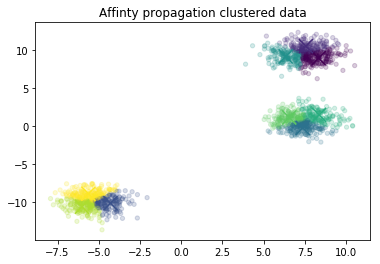

In [210]:
plt.scatter(x=data_1_wo_labels.iloc[:,0],y=data_1_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(n_clusters),s=200,linewidths=20)
plt.title("Affinty propagation clustered data")

We can see still the we get 9 clusters which are far too many for our problem.

We thus try to play around with the input preference as well.

According to this reply from Professor Bodenhofer regarding setting the input preference.

https://stackoverflow.com/questions/33187354/affinity-propagation-preferences-initialization

It was suggested to set the input preference to the minimal negative squared distance , which is the -1 * the maximum squared euclidean distance between two points in our dataset

So, for that purpose we implement a python method to calculate that value and set it to the input preference

In [19]:
def input_preference(data):
    
    distance_mat=np.zeros((data.shape[0],data.shape[0]))
    
    for i in range(data.shape[0]):
        
        for j in range(i+1,data.shape[0]):
            
            distance_mat[i,j]=euclidean_distances(data[i,:].reshape(1,-1),data[j,:].reshape(1,-1))
            distance_mat[j,i]=distance_mat[i,j]
    
    preference=-(distance_mat.max())**2
    
    return preference

In [20]:
preference=input_preference(X)
preference

-835.0780585362131

In [23]:
AP=AffinityPropagation(preference=preference,damping=0.9,affinity="euclidean")
AP.fit(X)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.9, max_iter=200, preference=-835.0780585362131,
          verbose=False)

In [24]:
n_clusters=AP.cluster_centers_.shape[0]
cluster_centers=AP.cluster_centers_
labels=AP.labels_
print("number of AP clusters =",n_clusters)

number of AP clusters = 3


Text(0.5,1,'Affinty propagation clustered data, Cluster=3')

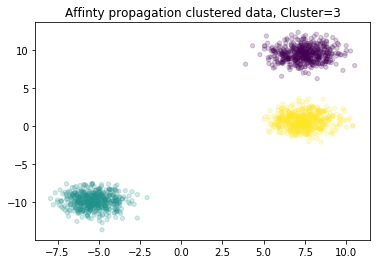

In [26]:
plt.scatter(x=data_1_wo_labels.iloc[:,0],y=data_1_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(n_clusters),s=200,linewidths=20)
plt.title("Affinty propagation clustered data, Cluster=3")

We can see that we are able to get exactly three identical clusters to the original dataset with that input preference setting

**Comparison between Kmeans and Affinity propagation:**

- In terms of results both methods are able to cluster the data in a way almost identical to 
the original clustering.
- However, since Kmeans is initialization prone the algorithm needs to be run multiple times with 
the same number of clusters and the most suitable result is then choosen. 
- On the other hand, AP produces deterministic results which are not dependent on the initialization. 
The algorithm has two hyperparameters the damping factor which could be set 
between 0.5 and 1 and the input preference.we could see here that setting the preference to
the minimal negative squared distance produces exactly the same original amount of clusters.
In my opinion it is a better choice in this case for this dataset as typically we don't know the no. of clusters beforehand for unsupervised problems thus in the Kmeans case we have to try many number of clusters while with AP we only could try a handful of damping factors and use a deterministic equation to set the input preference and we prefectly get the correct clustering.


# Dataset 2

We now analyze our second dataset and view the original clusters

Text(0.5,1,'Original data with Labels')

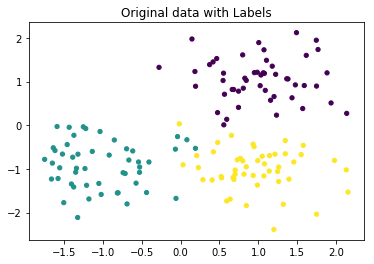

In [81]:
plt.scatter(x=data_2.iloc[:,0],y=data_2.iloc[:,1],c=data_2.iloc[:,2],s=18)
plt.title("Original data with Labels")

The dataset has 3 clusters with minimal overlapp.

In [82]:
data_2['label'].value_counts()

1.0    50
2.0    50
0.0    50
Name: label, dtype: int64

In [27]:
data_2_wo_labels=data_2.drop(columns=['label'])
X=data_2_wo_labels.values

**Kmeans**

Now we apply Kmeans with different number of clusters as an input and explore the clustering results.

In [129]:
k=2
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=2')

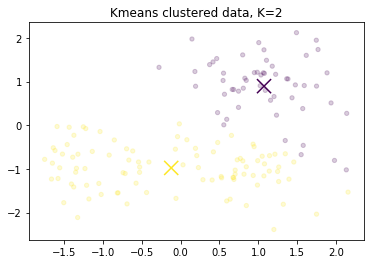

In [130]:
plt.scatter(x=data_2_wo_labels.iloc[:,0],y=data_2_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=2")

The above plot shows the results for K=2, we can see that the bottom to clusters are assigned to one cluster

In [131]:
k=3
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=3')

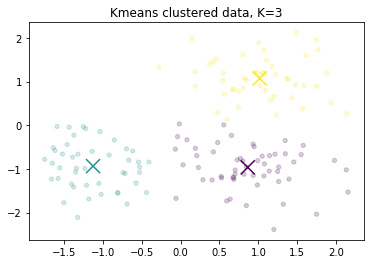

In [132]:
plt.scatter(x=data_2_wo_labels.iloc[:,0],y=data_2_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=3")

With K=3 , the clusters are very similar to the original ones. 
The overlapp between the bottom two clusters is assigned to the right cluster instead of the left one
as in the original clusters.


In [134]:
k=4
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=4')

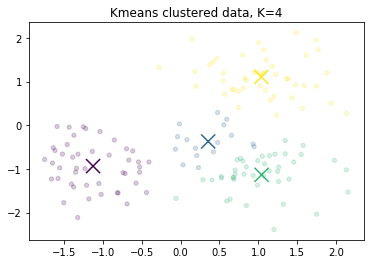

In [135]:
plt.scatter(x=data_2_wo_labels.iloc[:,0],y=data_2_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=4")

With K=4 the bottom right cluster is now split into two

In [138]:
k=5
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=5')

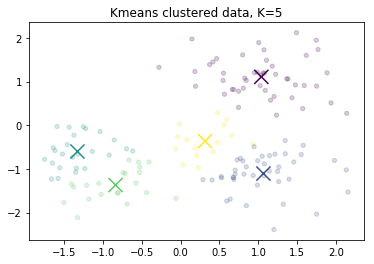

In [139]:
plt.scatter(x=data_2_wo_labels.iloc[:,0],y=data_2_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=5")

The results above are shown for K=5, the bottom two clusters are split into two each.

In [140]:
k=10
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=10')

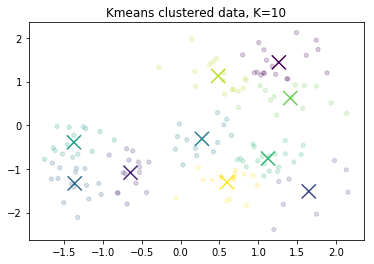

In [141]:
plt.scatter(x=data_2_wo_labels.iloc[:,0],y=data_2_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=10")

We tried and extreme value of K=10 and the results are as shown above.

**Affinity Propagation**

Next we apply Affinity propagation to our dataset
First, we set the input preference value to the median of the input similarities as with the previous dataset.

We play around with the damping factor a bit to obtain a reasonable number of clusters 


In [28]:
AP=AffinityPropagation(damping=0.9,affinity="euclidean",max_iter=1000)
AP.fit(X)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.9, max_iter=1000, preference=None, verbose=False)

In [29]:
n_clusters=AP.cluster_centers_.shape[0]
cluster_centers=AP.cluster_centers_
labels=AP.labels_
print("number of AP clusters =",n_clusters)
print(labels.shape)

number of AP clusters = 10
(150,)


Text(0.5,1,'Affinty propagation clustered data')

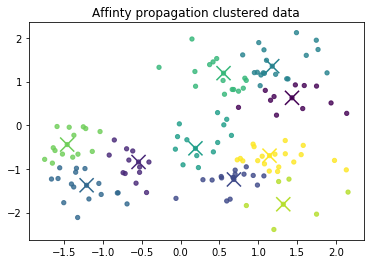

In [30]:
plt.scatter(x=data_2_wo_labels.iloc[:,0],y=data_2_wo_labels.iloc[:,1],c=labels,alpha=0.8,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(n_clusters),s=200,linewidths=20)
plt.title("Affinty propagation clustered data")

We can see that we get 10 clusters which is extreme for the problem beforehand

We now try setting the input preference to the minimal minimal negative squared distance and observe the results

In [31]:
AP=AffinityPropagation(preference=input_preference(X),damping=0.9,affinity="euclidean",max_iter=1000)
AP.fit(X)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.9, max_iter=1000, preference=-25.88068623141997,
          verbose=False)

In [32]:
n_clusters=AP.cluster_centers_.shape[0]
cluster_centers=AP.cluster_centers_
labels=AP.labels_
print("number of AP clusters =",n_clusters)
print(labels.shape)

number of AP clusters = 3
(150,)


Text(0.5,1,'Affinty propagation clustered data')

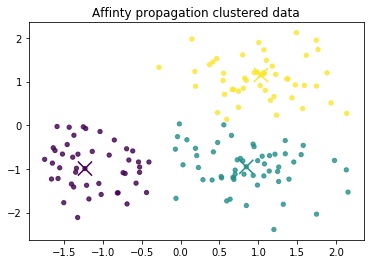

In [33]:
plt.scatter(x=data_2_wo_labels.iloc[:,0],y=data_2_wo_labels.iloc[:,1],c=labels,alpha=0.8,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(n_clusters),s=200,linewidths=20)
plt.title("Affinty propagation clustered data")

We can see from the above that we get very similar clusters to the original ones
with the overlapping area between the bottom two clusters assigned to the right cluster
instead of the left one in the original clusters.

**Comparison between Kmeans and Affinity propagation:**

- In terms of results both methods are able to cluster the data very similar to 
the original clustering.
- However, since Kmeans is initialization prone the algorithm needs to be run multiple times with 
the same number of clusters and the most suitable result is then choosen. 
- On the other hand, AP produces deterministic results which are not dependent on the initialization. 
The algorithm has two hyperparameters the damping factor which could be set 
between 0.5 and 1 and the input preference.we could see here that setting the preference to
the minimal negative squared distance produces exactly the same original amount of clusters.
In my opinion it is a better choice in this case for this dataset as typically 
we don't know the no. of clusters beforehand for unsupervised problems thus in 
the Kmeans case we have to try many number of clusters while with AP we only 
could try a handful of damping factors and use a deterministic equation 
to set the input preference and we prefectly get the correct clustering.


# Dataset 3

We analyze now our third and final dataset.

Text(0.5,1,'Original data with Labels')

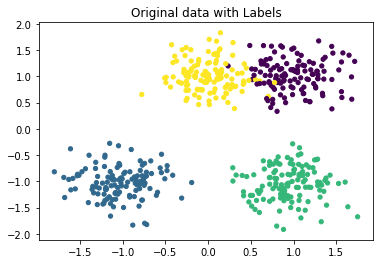

In [106]:
plt.scatter(x=data_3.iloc[:,0],y=data_3.iloc[:,1],c=data_3.iloc[:,2],s=18)
plt.title("Original data with Labels")

In [107]:
data_3['label'].value_counts()

3.0    125
1.0    125
0.0    125
2.0    125
Name: label, dtype: int64

We can see that the data consists of four clusters

In [60]:
data_3_wo_labels=data_3.drop(columns=['label'])
X=data_3_wo_labels.values

**Affinity Propagation**

we apply Affinity propagation to our dataset
First, we set the input preference value to the median of the input similarities as with the previous dataset.

We play around with the damping factor a bit to obtain a reasonable number of clusters 

In [63]:
AP=AffinityPropagation(damping=0.7,affinity="euclidean",max_iter=1000)
AP.fit(X)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.7, max_iter=1000, preference=None, verbose=False)

In [64]:
n_clusters=AP.cluster_centers_.shape[0]
cluster_centers=AP.cluster_centers_
labels=AP.labels_
print("number of AP clusters =",n_clusters)
print(labels.shape)

number of AP clusters = 11
(500,)


Text(0.5,1,'Affinty propagation clustered data')

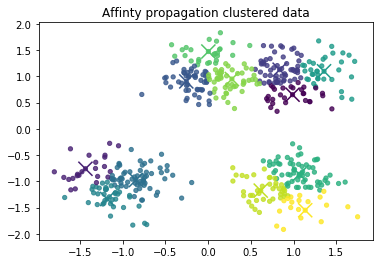

In [123]:
plt.scatter(x=data_3_wo_labels.iloc[:,0],y=data_3_wo_labels.iloc[:,1],c=labels,alpha=0.8,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(n_clusters),s=200,linewidths=20)
plt.title("Affinty propagation clustered data")

We can see that we get 11 clusters, which is too much for this dataset

As before,We now try setting the input preference to the minimal minimal negative squared distance and observe the results

In [38]:
AP=AffinityPropagation(preference=input_preference(X),damping=0.7,affinity="euclidean",max_iter=1000)
AP.fit(X)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
          damping=0.7, max_iter=1000, preference=-18.391577581729532,
          verbose=False)

In [39]:
n_clusters=AP.cluster_centers_.shape[0]
cluster_centers=AP.cluster_centers_
labels=AP.labels_
print("number of AP clusters =",n_clusters)
print(labels.shape)

number of AP clusters = 4
(500,)


Text(0.5,1,'Affinty propagation clustered data')

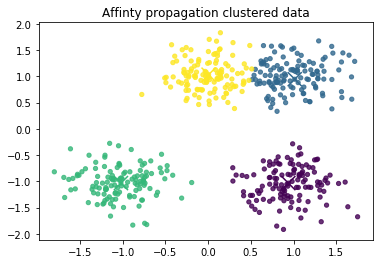

In [40]:
plt.scatter(x=data_3_wo_labels.iloc[:,0],y=data_3_wo_labels.iloc[:,1],c=labels,alpha=0.8,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(n_clusters),s=200,linewidths=20)
plt.title("Affinty propagation clustered data")

We can see that we get almost the same 4 clusters as the original ones

**Kmeans**

Now we apply KMeans to our dataset and explore the results for different K

In [143]:
k=2
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=2')

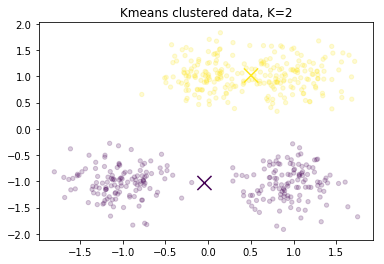

In [144]:
plt.scatter(x=data_3_wo_labels.iloc[:,0],y=data_3_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=2")

With K=2 the upper and bottom two clusters are grouped together

In [145]:
k=3
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=3')

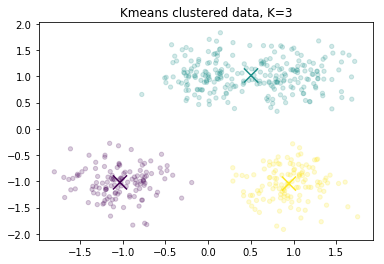

In [146]:
plt.scatter(x=data_3_wo_labels.iloc[:,0],y=data_3_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=3")

with K=3 we get the two original clusters at the bottom

In [147]:
k=4
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=4')

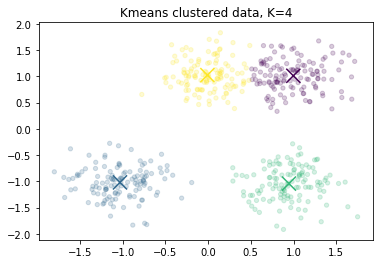

In [148]:
plt.scatter(x=data_3_wo_labels.iloc[:,0],y=data_3_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=4")

with K=4 we almost prefectly get the same original clusters

In [149]:
k=5
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=5')

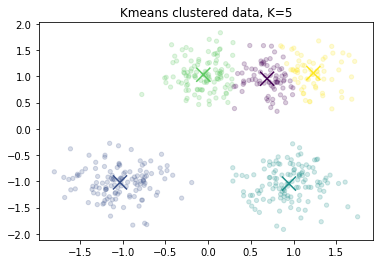

In [150]:
plt.scatter(x=data_3_wo_labels.iloc[:,0],y=data_3_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=5")

K=5, one of the above clusters is further split to produce the fifth cluster

In [151]:
k=12
Kmeans=KMeans(n_clusters=k,n_init=10).fit(X)

labels=Kmeans.labels_
cluster_centers=Kmeans.cluster_centers_

Text(0.5,1,'Kmeans clustered data, K=12')

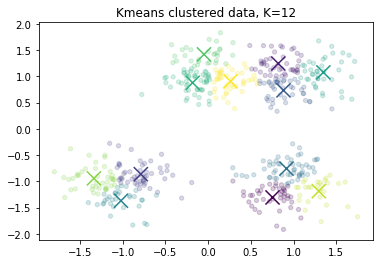

In [152]:
plt.scatter(x=data_3_wo_labels.iloc[:,0],y=data_3_wo_labels.iloc[:,1],c=labels,alpha=0.2,s=18)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker='x',c=np.arange(k),s=200,linewidths=20)
plt.title("Kmeans clustered data, K=12")

Finally, the results are should if we try a high value of K=12.

**Comparison between Kmeans and Affinity propagation:**

Again as in the case of the previous two datasets

- In terms of results both methods are able to cluster the data very similar to 
the original clustering.
- However, since Kmeans is initialization prone the algorithm needs to be run multiple times with 
the same number of clusters and the most suitable result is then choosen. 
- On the other hand, AP produces deterministic results which are not dependent on the initialization. 
The algorithm has two hyperparameters the damping factor which could be set 
between 0.5 and 1 and the input preference.we could see here that setting the preference to
the minimal negative squared distance produces exactly the same original amount of clusters.
In my opinion it is a better choice in this case for this dataset as typically 
we don't know the no. of clusters beforehand for unsupervised problems thus in 
the Kmeans case we have to try many number of clusters while with AP we only 
could try a handful of damping factors and use a deterministic equation 
to set the input preference and we prefectly get the correct clustering.